## Installing LibAUC

In [1]:
! pip install libauc==1.2.0
! pip install medmnist

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Importing LibAUC

In [2]:
from libauc.losses import AUCMLoss, APLoss, CrossEntropyLoss
from libauc.optimizers import PESG, SOAP, Adam
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score, auc_prc_score

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from libauc.models import resnet18
from medmnist import PneumoniaMNIST

In [3]:
# Modify ResNet18 to work with grayscale images
def get_resnet18():
    # Replace the first convolution layer of ResNet18(model.conv1) with a convolution layer of only 1 input channel(original ResNet is designed for RGB image input)
    model = resnet18(pretrained=False, last_activation=None)
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    return model

# HyperParameters

In [4]:
BATCH_SIZE = 64
total_epochs = 15
decay_epochs = [9]
weight_decay = 0

lrs_SOAP_and_Adam = [5e-4, 1e-3, 2e-3]
lrs_PESG = [0.02, 0.05, 0.1]
gammas_APLoss = [0.2, 0.5, 0.8]

imratio = 0.1
sampling_rate = 0.5

# **Loading datasets**

In [5]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=28, mode='train'):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
        self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
        
        
        # for loss function
        self.pos_indices = np.flatnonzero(targets==1)
        self.pos_index_map = {}
        for i, idx in enumerate(self.pos_indices):
            self.pos_index_map[idx] = i

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
           idx = self.pos_index_map[idx] if idx in self.pos_indices else -1
           image = self.transform_train(image)
        else:
           image = self.transform_test(image)
        return idx, image, target

# Load PneumoniaMNIST datasets
train_dataset = PneumoniaMNIST(split='train', download=True)
test_dataset = PneumoniaMNIST(split='test', download=True)

# generate imbalanced data
generator = ImbalancedDataGenerator(verbose=True, random_seed=0)
(train_images, train_labels) = generator.transform(train_dataset.imgs, train_dataset.labels, imratio=imratio)
(test_images, test_labels) = generator.transform(test_dataset.imgs, test_dataset.labels, imratio=0.5) 

# data augmentations 
trainSet = ImageDataset(train_images, train_labels)
trainSet_eval = ImageDataset(train_images, train_labels, mode='test')
testSet = ImageDataset(test_images, test_labels, mode='test')

# dataloaders
sampler = DualSampler(trainSet, BATCH_SIZE, sampling_rate=sampling_rate)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
trainloader_eval = torch.utils.data.DataLoader(trainSet_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Using downloaded and verified file: /home/grads/s/skpaul/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/grads/s/skpaul/.medmnist/pneumoniamnist.npz
#SAMPLES: [1348], POS:NEG: [134 : 1214], POS RATIO: 0.0994
#SAMPLES: [624], POS:NEG: [390 : 234], POS RATIO: 0.6250


# Training & Ploting

In [6]:
def train_model(model, loss_fn, optimizer, isAPLoss = False, num_epochs=15, decay_epochs=[9], model_name = ''):
    print ('\nStart Training :' + model_name)
    print ('-'*30)

    train_log_roc = []
    test_log_roc = []
    train_log_prc = []
    test_log_prc = []
    for epoch in range(num_epochs):
        if epoch in decay_epochs:
            if(hasattr(optimizer, 'update_regularizer')):
                optimizer.update_regularizer(decay_factor=10) # decrease learning rate by 10x & update regularizer
            elif(hasattr(optimizer, 'update_lr')):
                optimizer.update_lr(decay_factor=10)
    
        train_loss = []
        model.train()    
        for idx , data, targets in trainloader:
            data, targets  = data.cuda(), targets.cuda()
            y_pred = model(data)
            y_pred = torch.sigmoid(y_pred)
            if isAPLoss:
                loss = loss_fn(y_pred, targets, idx)
            else:
                loss = loss_fn(y_pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        
        # evaluation on train & test sets
        model.eval()
        train_pred_list = []
        train_true_list = []
        for idx, train_data, train_targets in trainloader_eval:
            train_data = train_data.cuda()
            train_pred = model(train_data)
            train_pred_list.append(train_pred.cpu().detach().numpy())
            train_true_list.append(train_targets.numpy())
        train_true = np.concatenate(train_true_list)
        train_pred = np.concatenate(train_pred_list)
        train_auc = auc_roc_score(train_true, train_pred)
        train_ap = auc_prc_score(train_true, train_pred)
        train_loss = np.mean(train_loss)
    
        test_pred_list = []
        test_true_list = [] 
        for idx, test_data, test_targets in testloader:
            test_data = test_data.cuda()
            test_pred = model(test_data)
            test_pred_list.append(test_pred.cpu().detach().numpy())
            test_true_list.append(test_targets.numpy())
        test_true = np.concatenate(test_true_list)
        test_pred = np.concatenate(test_pred_list)
        val_auc =  auc_roc_score(test_true, test_pred)
        test_ap = auc_prc_score(test_true, test_pred)
        model.train()
    
        # print results
        print("epoch: %s, train_auc: %.4f, test_auc: %.4f, train_ap: %.4f, test_ap: %.4f, lr: %.4f"%(epoch, train_auc, val_auc, train_ap, test_ap, optimizer.lr ))    
        train_log_roc.append(train_auc) 
        test_log_roc.append(val_auc)
        train_log_prc.append(train_ap)
        test_log_prc.append(test_ap)
    return  train_log_roc, test_log_roc, train_log_prc, test_log_prc

In [7]:
import matplotlib.pyplot as plt
def plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name):
    #plt.rcParams["figure.figsize"] = (9,5)
    x=np.arange(len(train_auroc))
    plt.figure()
    plt.plot(x, train_auroc, linestyle='-', label='Train AUROC', linewidth=3)
    plt.plot(x, test_auroc,  linestyle='-', label='Test AUROC', linewidth=3)
    plt.plot(x, train_auprc, linestyle='--', label='Train AUPRC', linewidth=3)
    plt.plot(x, test_auprc,  linestyle='--', label='Test AUPRC', linewidth=3)
    plt.title(f'AUPRC and AUROC for {model_name}')
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Epoch')

# (i)APLoss and SOAP optimizer with ’Adam’ mode.


Start Training :LR:0.0005, gamma: 0.2, APLoss + SOAP (Adam mode)
------------------------------
epoch: 0, train_auc: 0.9729, test_auc: 0.9104, train_ap: 0.9053, test_ap: 0.9302, lr: 0.0005
epoch: 1, train_auc: 0.9841, test_auc: 0.9250, train_ap: 0.9594, test_ap: 0.9474, lr: 0.0005
epoch: 2, train_auc: 0.9833, test_auc: 0.9186, train_ap: 0.9609, test_ap: 0.9373, lr: 0.0005
epoch: 3, train_auc: 0.9844, test_auc: 0.9376, train_ap: 0.9689, test_ap: 0.9572, lr: 0.0005
epoch: 4, train_auc: 0.9896, test_auc: 0.9224, train_ap: 0.9789, test_ap: 0.9430, lr: 0.0005
epoch: 5, train_auc: 0.9878, test_auc: 0.9210, train_ap: 0.9792, test_ap: 0.9389, lr: 0.0005
epoch: 6, train_auc: 0.9887, test_auc: 0.9202, train_ap: 0.9862, test_ap: 0.9415, lr: 0.0005
epoch: 7, train_auc: 0.9895, test_auc: 0.9449, train_ap: 0.9836, test_ap: 0.9622, lr: 0.0005
epoch: 8, train_auc: 0.9907, test_auc: 0.9242, train_ap: 0.9876, test_ap: 0.9471, lr: 0.0005
Reducing learning rate to 0.00005 @ T=333!
epoch: 9, train_auc: 0.

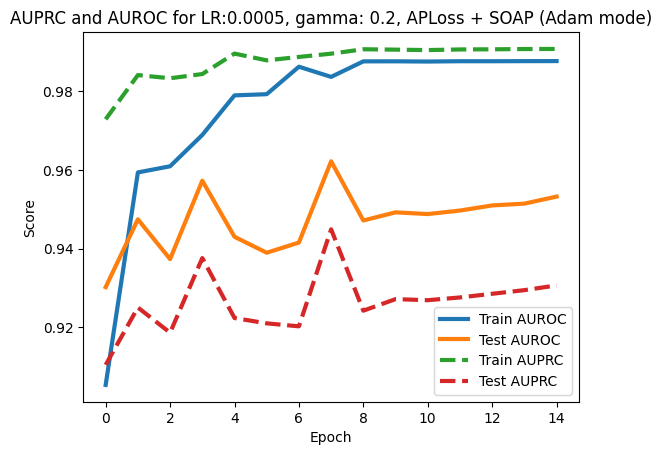

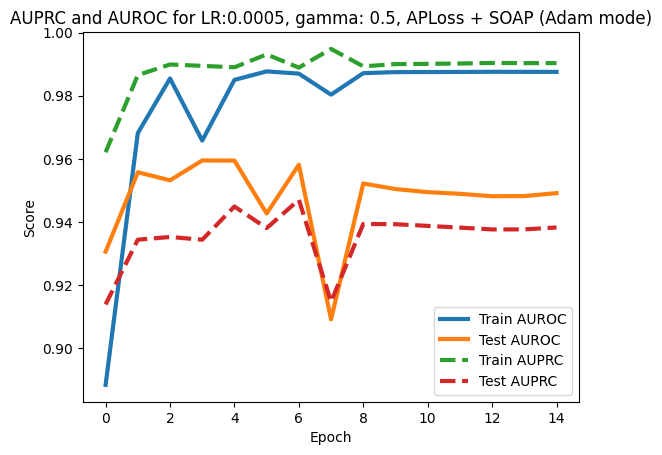

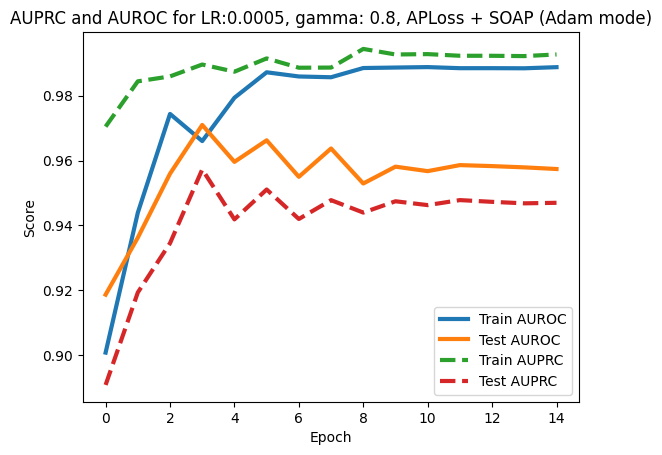

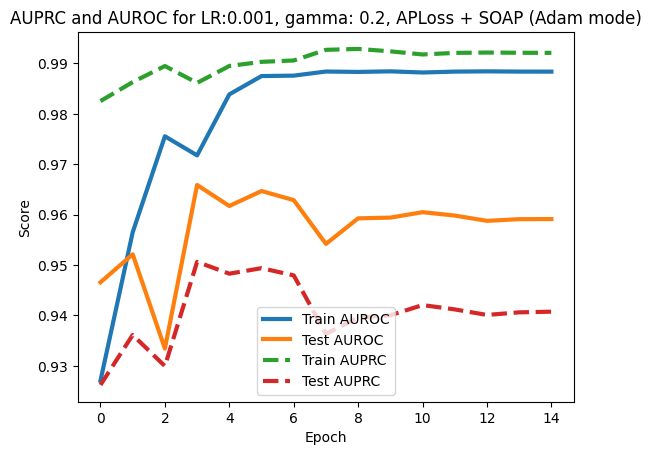

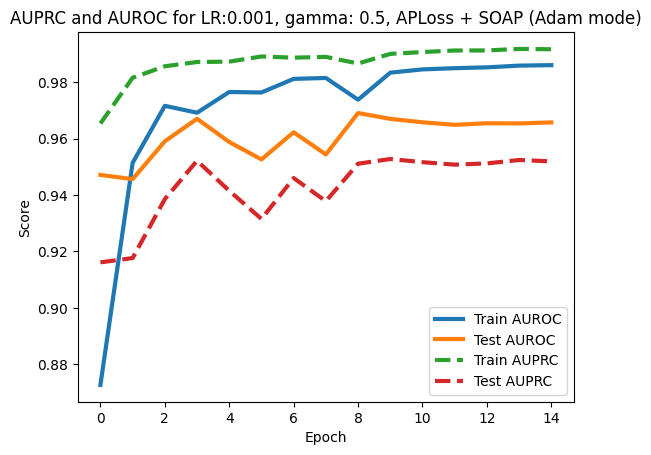

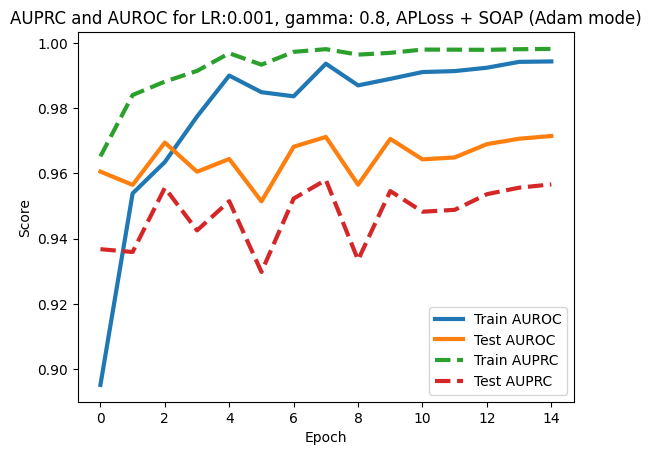

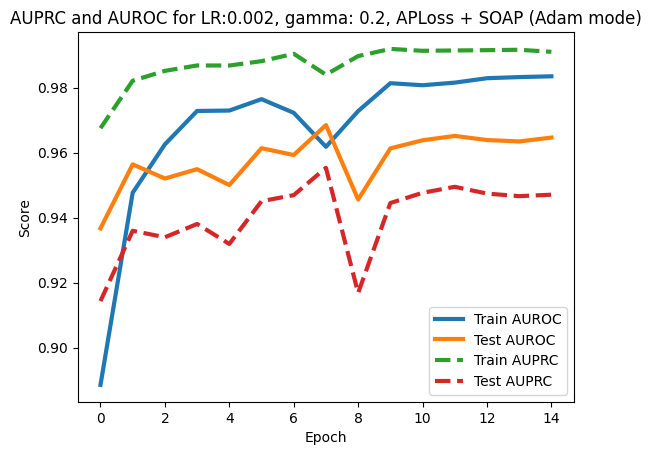

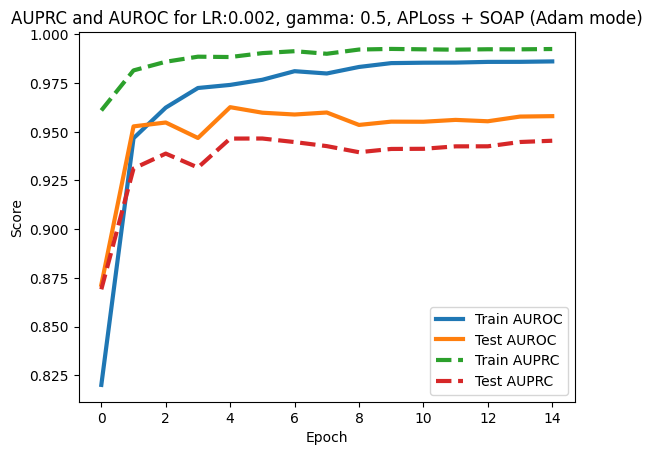

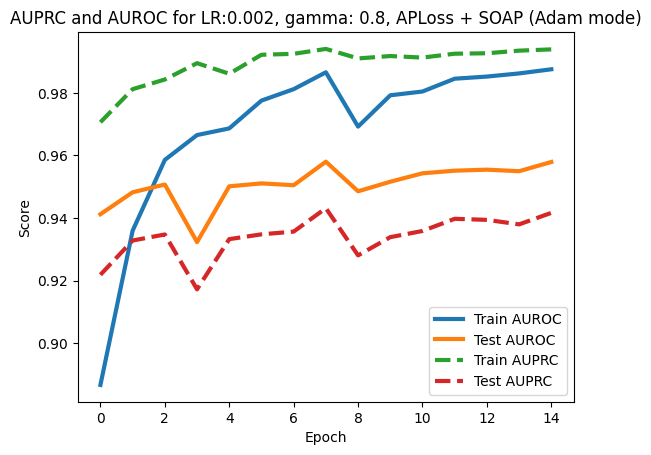

In [8]:
for lr_soap in lrs_SOAP_and_Adam:
    for gamma_aploss in gammas_APLoss:
        model_APloss = get_resnet18()
        model_APloss = model_APloss.cuda()
        model_name_APloss = f'LR:{lr_soap}, gamma: {gamma_aploss}, APLoss + SOAP (Adam mode)'
        loss_fn_APLoss = APLoss(pos_len=sampler.pos_len, margin=0.6, gamma=gamma_aploss)
        optimizer_SOAP = SOAP(model_APloss.parameters(), lr=lr_soap, mode='adam', weight_decay=weight_decay)
        train_auprc, test_auprc, train_auroc, test_auroc = train_model(model=model_APloss, loss_fn=loss_fn_APLoss, 
                                                                       optimizer=optimizer_SOAP, isAPLoss=True, 
                                                                       model_name=model_name_APloss)
        plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name_APloss)

# (ii) AUCMLoss and PESG optimizer with ’Adam’ mode.


Start Training :LR:0.02, AUCMLoss + PESG (Adam mode)
------------------------------
epoch: 0, train_auc: 0.9069, test_auc: 0.8019, train_ap: 0.6408, test_ap: 0.8399, lr: 0.0200
epoch: 1, train_auc: 0.9987, test_auc: 0.9270, train_ap: 0.9915, test_ap: 0.9454, lr: 0.0200
epoch: 2, train_auc: 0.9988, test_auc: 0.9347, train_ap: 0.9955, test_ap: 0.9555, lr: 0.0200
epoch: 3, train_auc: 1.0000, test_auc: 0.9374, train_ap: 0.9997, test_ap: 0.9572, lr: 0.0200
epoch: 4, train_auc: 1.0000, test_auc: 0.9347, train_ap: 1.0000, test_ap: 0.9562, lr: 0.0200
epoch: 5, train_auc: 1.0000, test_auc: 0.9327, train_ap: 1.0000, test_ap: 0.9516, lr: 0.0200
epoch: 6, train_auc: 1.0000, test_auc: 0.9348, train_ap: 1.0000, test_ap: 0.9539, lr: 0.0200
epoch: 7, train_auc: 1.0000, test_auc: 0.9367, train_ap: 1.0000, test_ap: 0.9560, lr: 0.0200
epoch: 8, train_auc: 1.0000, test_auc: 0.9380, train_ap: 1.0000, test_ap: 0.9569, lr: 0.0200
Reducing learning rate to 0.00200 @ T=333!
Updating regularizer @ T=333!
epoch

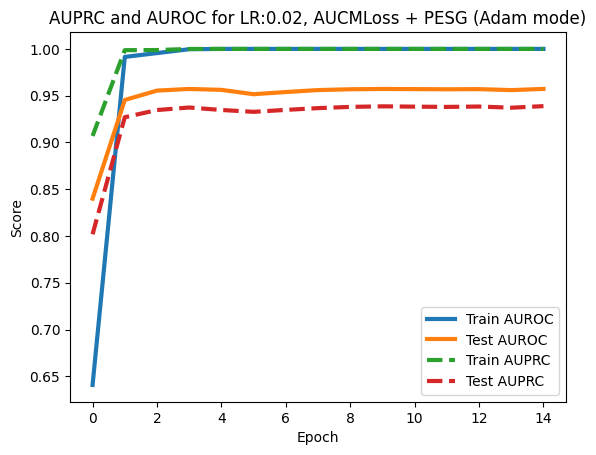

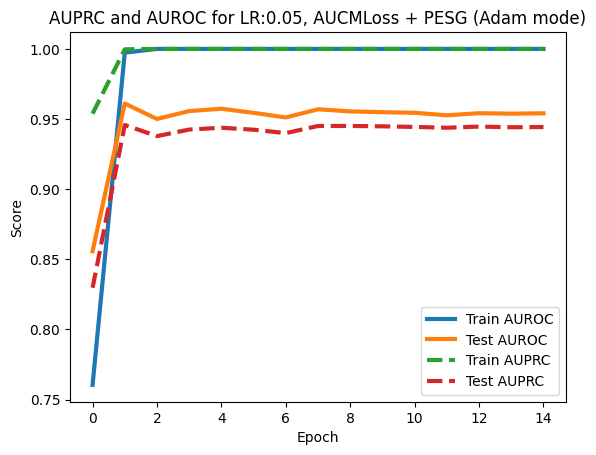

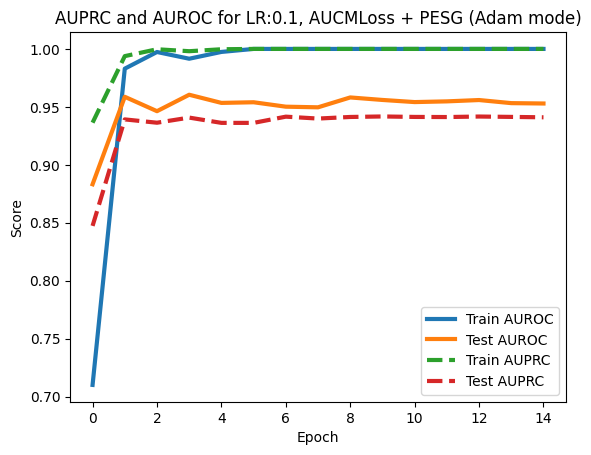

In [9]:
for lr_pesg in lrs_PESG:
    model_AUCMLoss = get_resnet18()
    model_AUCMLoss = model_AUCMLoss.cuda()
    model_name_AUCMLoss = f'LR:{lr_pesg}, AUCMLoss + PESG (Adam mode)'
    loss_fn_AUCMLoss = AUCMLoss()
    optimizer_PESG = PESG(model=model_AUCMLoss, 
                    loss_fn=loss_fn_AUCMLoss,
                    lr=lr_pesg,
                    mode='Adam',
                    weight_decay=weight_decay)
    train_auprc, test_auprc, train_auroc, test_auroc = train_model(model=model_AUCMLoss, loss_fn=loss_fn_AUCMLoss, 
                                                                   optimizer=optimizer_PESG, model_name=model_name_AUCMLoss)
    plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name=model_name_AUCMLoss)

# (iii) CE loss and Adam optimizer


Start Training :LR:0.0005, CE Loss + Adam
------------------------------
epoch: 0, train_auc: 0.9662, test_auc: 0.8569, train_ap: 0.8486, test_ap: 0.8774, lr: 0.0005
epoch: 1, train_auc: 0.9812, test_auc: 0.9389, train_ap: 0.9465, test_ap: 0.9569, lr: 0.0005
epoch: 2, train_auc: 0.9837, test_auc: 0.9193, train_ap: 0.9434, test_ap: 0.9055, lr: 0.0005
epoch: 3, train_auc: 0.9819, test_auc: 0.8853, train_ap: 0.9232, test_ap: 0.9118, lr: 0.0005
epoch: 4, train_auc: 0.9826, test_auc: 0.9429, train_ap: 0.9503, test_ap: 0.9637, lr: 0.0005
epoch: 5, train_auc: 0.9865, test_auc: 0.9199, train_ap: 0.9598, test_ap: 0.9357, lr: 0.0005
epoch: 6, train_auc: 0.9874, test_auc: 0.9225, train_ap: 0.9602, test_ap: 0.9230, lr: 0.0005
epoch: 7, train_auc: 0.9845, test_auc: 0.9417, train_ap: 0.9648, test_ap: 0.9551, lr: 0.0005
epoch: 8, train_auc: 0.9857, test_auc: 0.9422, train_ap: 0.9642, test_ap: 0.9448, lr: 0.0005
Reducing learning rate to 0.00005 !
epoch: 9, train_auc: 0.9860, test_auc: 0.9404, train_

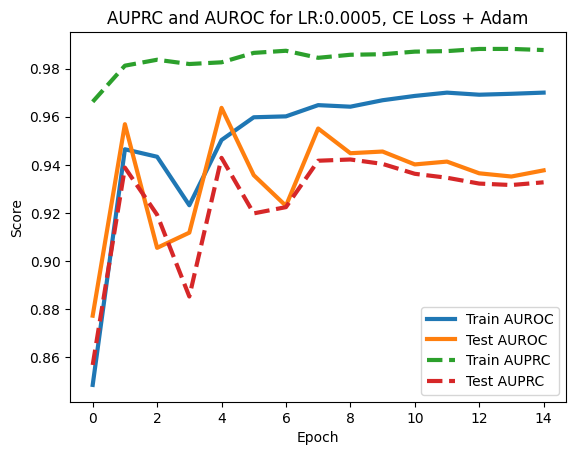

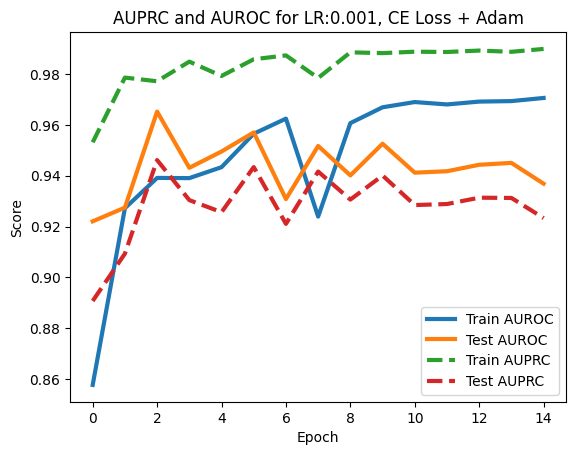

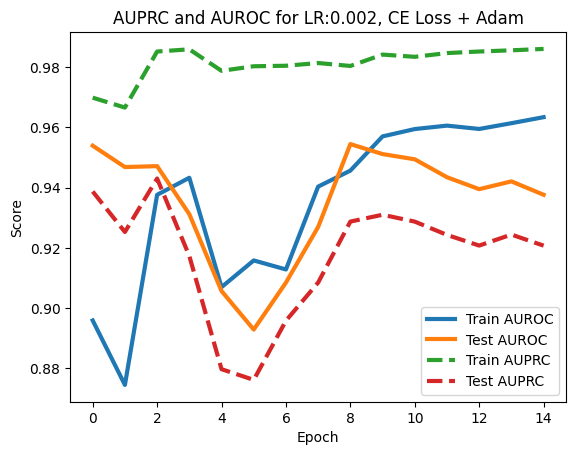

In [10]:
for lr_adam in lrs_SOAP_and_Adam:
    model_CE = get_resnet18()
    model_CE = model_CE.cuda()
    model_name_CE = f'LR:{lr_adam}, CE Loss + Adam'
    loss_fn_CE = CrossEntropyLoss()
    optimizer_Adam = Adam(model_CE,
                    lr=lr_adam,
                    weight_decay=weight_decay)
    train_auprc, test_auprc, train_auroc, test_auroc = train_model(model=model_CE, loss_fn=loss_fn_CE, 
                                                                   optimizer=optimizer_Adam, model_name=model_name_CE)
    plot_curves(train_auprc, test_auprc, train_auroc, test_auroc, model_name_CE)